In [2]:
import requests
from PIL import Image
import io
import string

vocab = string.ascii_letters + string.digits

def get_captcha_image():
    response = requests.get('https://apply.jtw.beijing.gov.cn/apply/app/common/validCodeImage')
    cookie = response.cookies.get_dict()  # 获取cookie
    image = Image.open(io.BytesIO(response.content))  # 获取图片
    return image, cookie

def check_captcha(captcha_text, cookie):
    headers = {
        'cookie': f"JSESSIONID={cookie['JSESSIONID']}"
    }
    url = f"https://apply.jtw.beijing.gov.cn/apply/app/common/checkValidCode?validCode={captcha_text}"
    response = requests.get(url, headers=headers)
    return response.json()
# 图像预处理
def preprocess_image(image):
    image = image.convert('L')  # 灰度化
    threshold = 200
    table = []
    for i in range(256):
        if i < threshold:
            table.append(0)
        else:
            table.append(1)
    image = image.point(table, '1')  # 二值化
    return image

In [3]:
# list all ttf fonts in the font directory
import os
font_dir = 'fonts'
fonts = []
for root, dirs, files in os.walk(font_dir):
    for file in files:
        if file.endswith('.ttf'):
            fonts.append(os.path.join(root, file))
print(fonts)



['fonts/DejaVuSansMono-Regular.ttf', 'fonts/NotoSerif-Regular.ttf', 'fonts/DejaVuSerif-Regular.ttf', 'fonts/Amiri-Regular.ttf', 'fonts/KawkabMono-Regular.ttf', 'fonts/Catamaran-Regular.ttf', 'fonts/DavidLibre-Regular.ttf', 'fonts/NotoSans-Regular.ttf', 'fonts/LinusLibertinus-Regular.ttf', 'fonts/Lato-Regular.ttf', 'fonts/Halant-Regular.ttf', 'fonts/NotoSansMono-Regular.ttf', 'fonts/InconsolataSugar-Regular.ttf', 'fonts/IBMPlexMono-Regular.ttf', 'fonts/DejaVuSansMonoForConso1as-Regular.ttf', 'fonts/Cousine-Regular.ttf', 'fonts/DejaVuSans-Regular.ttf']


In [4]:
import string
import random
from captcha.image import ImageCaptcha

def generate_captcha():
    characters = string.ascii_letters + string.digits
    captcha = ''.join(random.choices(characters, k=4))
    image = ImageCaptcha(width=112,height=35,font_sizes=[30,36],fonts=fonts).generate_image(captcha)
    return image, captcha


(112, 35)


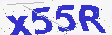

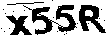

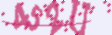

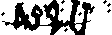

In [32]:
# 示例使用
image, cookie = get_captcha_image()

# image info
print(image.size)
# show image
from IPython.display import display
display(image)
display(preprocess_image(image))

image, captcha = generate_captcha()
display(image)
display(preprocess_image(image))

In [6]:
# OCR model assuming the image is 112x35 and the captcha is 4 characters long
import torch
import torch.nn.init as init
from torchvision import transforms

class CaptchaOCR(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.model = torch.nn.Sequential(
            torch.nn.Conv2d(1, 32, kernel_size=3, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2),
            torch.nn.Conv2d(32, 64, kernel_size=3, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2),
            torch.nn.Conv2d(64, 128, kernel_size=3, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2),
            torch.nn.Flatten(),
            torch.nn.Linear(7168, 256),
            torch.nn.ReLU(),
            # 4 characters in one-hot encoding
            torch.nn.Linear(256, 4*62)
        )
        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, torch.nn.Conv2d):
                init.xavier_uniform_(m.weight)  # Xavier initialization for Conv layers
                if m.bias is not None:
                    init.zeros_(m.bias)  # Set bias to zero
            elif isinstance(m, torch.nn.Linear):
                init.xavier_uniform_(m.weight)  # Xavier initialization for Linear layers
                init.zeros_(m.bias)  # Set bias to zero

    def forward(self, x):
        return self.model(x)
    
    def predict(self, x):
        with torch.no_grad():
            return self.model(x).view(-1, 4, 62).argmax(dim=-1)
    
    def predict_all_possible(self, x):
        with torch.no_grad():
            # Get each character's probabilities
            probs = self.model(x).view(-1, 4, 62).softmax(dim=-1)

            # Generate all combinations of indices for each character position
            all_indices = torch.cartesian_prod(
                torch.arange(62),  # For first character
                torch.arange(62),  # For second character
                torch.arange(62),  # For third character
                torch.arange(62)   # For fourth character
            ).to(probs.device)  # Ensure this tensor is on the same device as probs

            # Gather the probabilities for each combination
            word_probs = probs[0, torch.arange(4).unsqueeze(1), all_indices.T].prod(dim=0)

            # Sort the word combinations by probability
            sorted_probs, sorted_idx = word_probs.sort(descending=True)

            words = []
            # Return the top 10 word list with probabilities
            for i in range(10):
                word = ''.join([vocab[idx.item()] for idx in all_indices[sorted_idx[i]]])
                words.append((word, sorted_probs[i].item()))

            return words
        

In [7]:
# generate captcha dataset
from torch.utils.data import Dataset
import concurrent.futures

def generate_and_preprocess(_):
    image, captcha = generate_captcha()
    image = preprocess_image(image)
    image_tensor = transforms.ToTensor()(image)
    
    # Generate one-hot encoded label
    label = torch.zeros(4, 62)
    for i, char in enumerate(captcha):
        label[i][vocab.index(char)] = 1
    
    return image_tensor, label

class CaptchaDataset(Dataset):
    def __init__(self, n=1000):
        self.data = []
        self.labels = []
        
        with concurrent.futures.ProcessPoolExecutor() as executor:
            results = list(executor.map(generate_and_preprocess, range(n)))
        
        for image_tensor, label in results:
            self.data.append(image_tensor)
            self.labels.append(label)
            
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]


In [8]:
model = CaptchaOCR()
import os
if os.path.exists('captcha_ocr.pth'):
    model.load_state_dict(torch.load('captcha_ocr.pth'))

/tmp/ipykernel_3221186/3531243859.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('captcha_ocr.pth'))


In [9]:
from torch.utils.data import DataLoader

dataset = CaptchaDataset(50000)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True,drop_last=True)

In [11]:
# train model
import torch.optim as optim
from tqdm.notebook import tqdm

optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()

for epoch in range(5):
    for x, y in tqdm(dataloader):
        y_pred = model(x)
        loss = criterion(y_pred, y.reshape(-1, 4*62))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    accuracy = (model.predict(x) == y.argmax(dim=-1)).float().mean()
    tqdm.write(f'Loss: {loss.item()} Accuracy: {accuracy.item()}')
    

  0%|          | 0/1562 [00:00<?, ?it/s]

KeyboardInterrupt: 

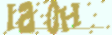

IaoH


[('Ia0H', 0.06032911315560341),
 ('la0H', 0.029110917821526527),
 ('IaoH', 0.02401287667453289),
 ('1a0H', 0.023732008412480354),
 ('Ta0H', 0.01808467134833336),
 ('Ia8H', 0.01584489271044731),
 ('IaaH', 0.015074959956109524),
 ('IauH', 0.01480201818048954),
 ('Ia6H', 0.014770656824111938),
 ('ja0H', 0.014573508873581886)]

In [35]:
# test model
image, captcha = generate_captcha()
display(image)
print(captcha)
image = preprocess_image(image)
x = transforms.ToTensor()(image).unsqueeze(0)
y_pred = model.predict_all_possible(x)
y_pred

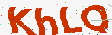

[('kkLO', 0.19830414652824402),
 ('kkLC', 0.1429942101240158),
 ('kALO', 0.06354735046625137),
 ('KkLO', 0.05360560119152069),
 ('kALC', 0.04582305997610092),
 ('KkLC', 0.03865421563386917),
 ('kHLO', 0.033374179154634476),
 ('kHLC', 0.02406563051044941),
 ('kLLO', 0.019662747159600258),
 ('kkLG', 0.01906098611652851)]

In [36]:
# test model on real captcha
image, cookie = get_captcha_image()
display(image)

image = preprocess_image(image)
x = transforms.ToTensor()(image).unsqueeze(0)
y_pred = model.predict_all_possible(x)
y_pred

In [ ]:
# save model
torch.save(model.state_dict(), 'captcha_ocr.pth')